In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from IPython.display import clear_output
#from IPython.display import SVG

In [10]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [11]:
get_available_gpus()

[]

# Import binary data

In [17]:
data = np.fromfile("/home/philip/RemoteFNAL/Pandora_v08_00_00_13/OutTest/viewU3.bin", dtype=np.float32)
np.shape(data)

(8425269,)

In [18]:
data[0:10]

array([ 1.2200000e+00,  0.0000000e+00,  0.0000000e+00,  2.9830759e+01,
       -1.0144005e+02,  1.2391226e-04,  0.0000000e+00,  0.0000000e+00,
        1.0000000e+00,  4.2437965e+01], dtype=float32)

In [19]:
ss = np.where(data==1.22)[0]
print(ss)

[      0   28509   64362   93867  114618  145707  160092  184179  221658
  261657  291924  325203  355380  389043  428664  470169  494946  525429
  575724  595611  631854  676761  694380  740721  784824  818409  857706
  900999  926736  952761  983970 1021773 1053846 1085415 1115850 1142001
 1200996 1242435 1268424 1300005 1323192 1356651 1407150 1439943 1461402
 1502985 1540164 1581327 1607610 1630371 1648980 1720851 1748412 1784589
 1812624 1845309 1872720 1915221 1950696 1974783 2030214 2072223 2098620
 2150331 2195280 2237655 2278164 2300139 2349384 2385147 2431698 2453397
 2482086 2516109 2550516 2569149 2611476 2641335 2663100 2688147 2729934
 2777085 2799102 2834925 2867178 2898237 2932344 2959383 2983086 3022029
 3052194 3097161 3120588 3146139 3192990 3232971 3269304 3307023 3337884
 3363855 3404712 3456783 3498288 3535287 3601548 3634893 3658860 3684447
 3714120 3727101 3768714 3829947 3870030 3906705 3940194 3989049 4027590
 4058451 4086600 4137687 4167390 4191981 4219056 42

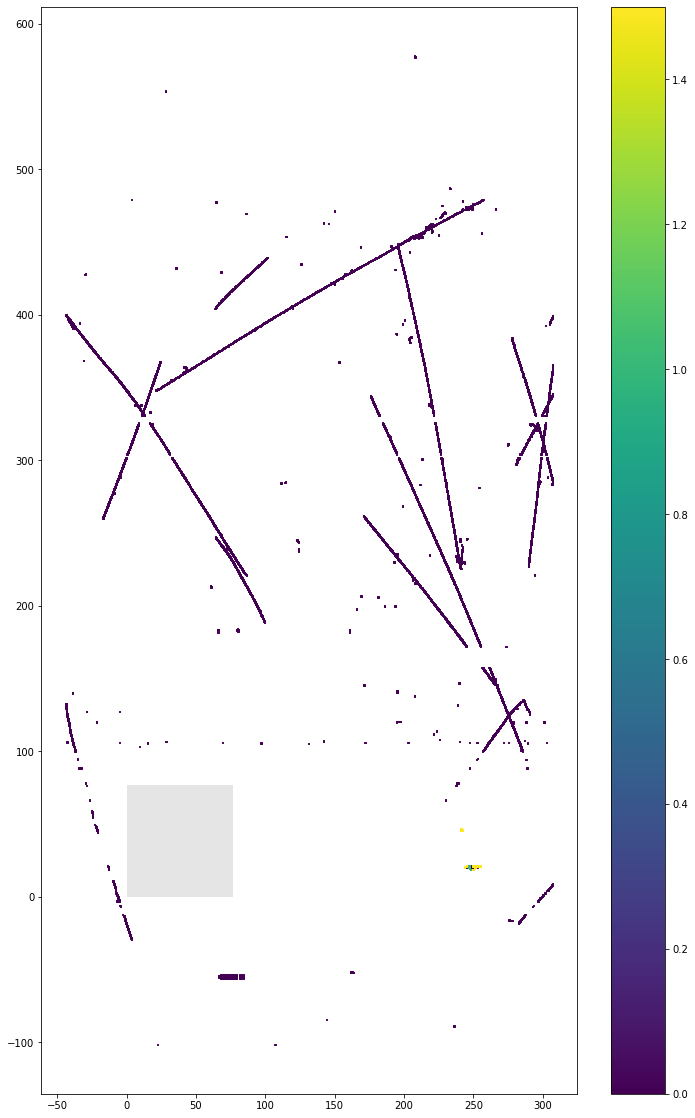

In [33]:
from matplotlib.transforms import Bbox
from matplotlib.path import Path

# 9, 10, 11?

i = 12
minX = data[1+ss[i]]
minZ = data[2+ss[i]]
x = data[3+ss[i]:ss[i+1]:6]
z = data[4+ss[i]:ss[i+1]:6]
E = data[5+ss[i]:ss[i+1]:6]
s = data[6+ss[i]:ss[i+1]:6]
p = data[7+ss[i]:ss[i+1]:6]
o = data[8+ss[i]:ss[i+1]:6]


# mask = np.where(o<0.85)
fig, ax = plt.subplots(figsize=(12,20))
#plt.figure(figsize=(10,20))
plt.scatter(x, z, c=(1.5*s+p), s=2, marker=",")
rect = plt.Rectangle((minX,minZ),256*0.3,256*0.3, facecolor="black", alpha=0.1)
ax.add_patch(rect)
plt.colorbar()
#plt.savefig('plotProton.png')
plt.show()

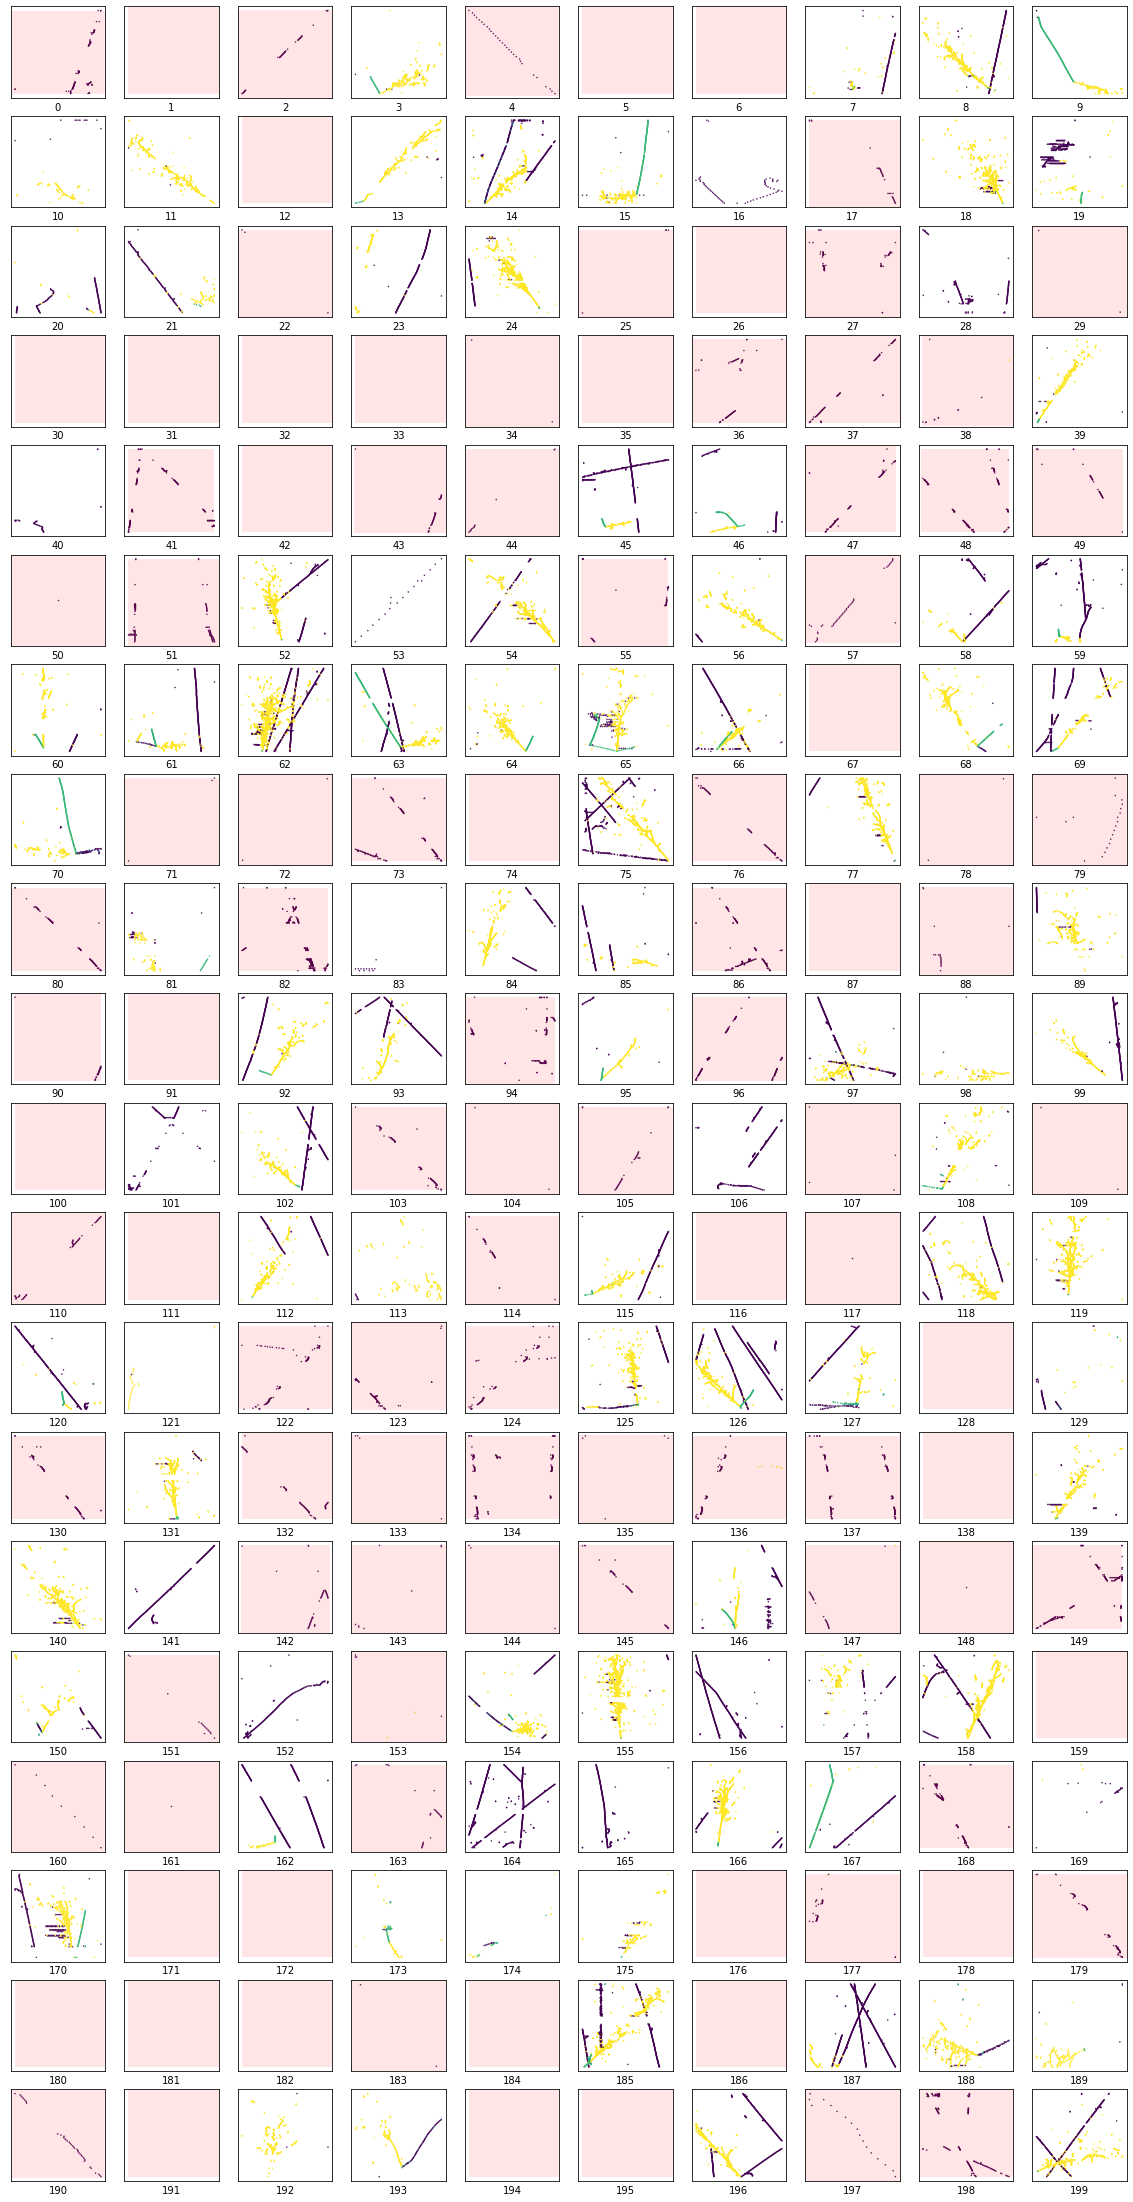

In [21]:
plt.figure(figsize=(20,40))
for i in range(200):
    minX = data[1+ss[i]]
    minZ = data[2+ss[i]]
    x = data[3+ss[i]:ss[i+1]:6]-minX
    z = data[4+ss[i]:ss[i+1]:6]-minZ 
    s = data[6+ss[i]:ss[i+1]:6]
    p = data[7+ss[i]:ss[i+1]:6]
    
    xMask = np.bitwise_and(x<256*0.3, x>0)
    zMask = np.bitwise_and(z<256*0.3, z>0)
    mask = np.bitwise_and(xMask, zMask)
    x = x[mask]
    z = z[mask]
    s = s[mask]
    p = p[mask]
    
    ax = plt.subplot(20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.scatter(x, z, c=(1.5*s+p), s=1, marker=".")
    plt.xlabel(i)
    
    if(minZ==0 and minX==0):#<0.1 and minZ>-0.1 and minX<0.1 and minX>-0.1):
        rect = plt.Rectangle((0,0),256*0.3,256*0.3, facecolor="red", alpha=0.1)
        ax.add_patch(rect)
plt.show()


# Other

In [150]:
IMSIZE = 256
FRAME_NUM = int(np.size(data)/(IMSIZE*IMSIZE*4))
reshaped_data = data.reshape((FRAME_NUM, IMSIZE,IMSIZE,4))
frames = tf.expand_dims(reshaped_data[:,:,:,0],3) # expand_dim: (x,256,256) -> (x,256,256,1)
masks = reshaped_data[:,:,:,1:]

ValueError: cannot reshape array of size 128496 into shape (0,256,256,4)

In [10]:
def normalize(input_frame, input_mask):
    input_frame = tf.cast(input_frame, tf.float16) / 255.0
    input_mask = tf.cast(input_mask, tf.float16)/255.0
    return input_frame, input_mask

@tf.function
def load_frame(frame, mask):
    frame, mask = normalize(frame, mask)
    return frame, mask

In [11]:
#TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
n = 4*FRAME_NUM//5 # Split percentage
train_dataset = tf.data.Dataset.from_tensor_slices((frames[:n], masks[:n]))
test_dataset = tf.data.Dataset.from_tensor_slices((frames[n:], masks[n:]))

In [13]:
train = train_dataset.map(load_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_frame)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# Display Data

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Frame', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

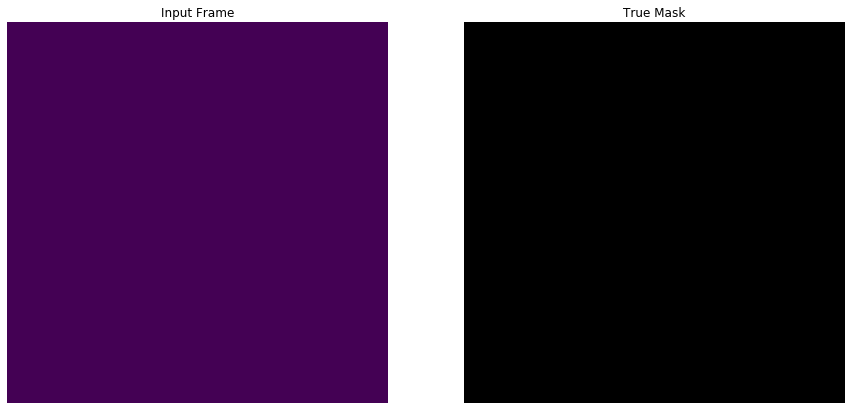

In [18]:
for frame, mask in train.take(1):
    sample_frame, sample_mask = frame, mask
display([sample_frame, sample_mask])

# ResNet Layer Definition

In [19]:
# Adapted from https://keras.io/examples/cifar10_resnet/

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

In [20]:
def downsample(filters, size, strides=1, activation=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

    result.add(tf.keras.layers.BatchNormalization())
    
    if activation:
        result.add(tf.keras.layers.ReLU())
    return result

SyntaxError: invalid syntax (<ipython-input-20-10730f74442d>, line 4)

In [ ]:
def down_residual_block(filters, kernel_size, downsampling=True):
    result = tf.keras.Sequential()
    
    if(downsampling) stride = 2
    else stride = 1
    
    for i in range(3):
        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=stride,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=1,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ReLU())
        stride = 1
    return result

In [ ]:
down_stack = [
    down_residual_block(16, 3),
    down_residual_block(32, 3),
    down_residual_block(64, 3),
    down_residual_block(128, 3),
    down_residual_block(256, 3, downsampling=False),
]

# Upsample Layer Definition

In [ ]:
def upsample(filters, size):

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def up_residual_block(filters, kernel_size, downsampling=True):
    result = tf.keras.Sequential()
    
    if(downsampling) stride = 2
    else stride = 1
    
    for i in range(3):
        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=stride,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=1,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ReLU())
        stride = 1
    return result

In [ ]:
up_stack = [
    upsample(256, 3),  # 4x4 -> 8x8
    upsample(128, 3),  # 8x8 -> 16x16
    upsample(64, 3),  # 16x16 -> 32x32
    upsample(32, 3),   # 32x32 -> 64x64
    #upsample(16, 3),
]

# U-Net Model Definition

In [14]:
OUTPUT_CHANNELS = 3

In [25]:
def u_resnet(output_channels, depth):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)    
    skips = [None]*5
    
    # Instantiate the stack of residual units
    conv1 = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    
    conv2 = tf.keras.layers.Conv2D(num_filters,
              kernel_size=3,
              strides=2,
              padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    
    convTrans = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=3, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False)
    concat = tf.keras.layers.Concatenate()
    
    
    ####### Beginning of U-ResNet #######
    #####################################
    inputs = tf.keras.layers.Input(shape=[IMSIZE, IMSIZE, 1])
    x = conv1(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(y)
    x = tf.keras.layers.Activation('relu')(y)
    
    
    
    ####### Beginning of Downsampling ResNet
    for stack in range(5):
        for res_block in range(num_res_blocks):
            doDownsample = (stack > 0 and res_block == 0) # first layer but not first stack           
            y = conv2(x) if doDownsample else conv1(x)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.Activation('relu')(y)
            y = conv1(y)
            y = tf.keras.layers.BatchNormalization()(y)
            if doDownsample: # linear projection residual shortcut connection to match changed dims
                x = tf.keras.layers.Conv2D(num_filters, kernel_size=1, strides=2, 
                                           padding='same', kernel_initializer='he_normal', 
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4))

            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    ####### End of Downsampling ResNet
    
    ####### Beginning of Upsampling ResNet
    for stack in range(4):
        for res_block in range(num_res_blocks):
            doUpsample = (stack < 4 and res_block == 0) # first layer but not last stack            
            if doUpsample:
                x = convTrans(x)
                y = concat([x, skips[-(stack+1)]])    
            else:
                conv1(x)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.Activation('relu')(y)
            y = conv1(y)
            y = tf.keras.layers.BatchNormalization()(y)
            if doUpsample: # linear projection residual shortcut connection to match changed dims
                x = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=1, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False)

            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        num_filters /= 2
    ####### End of Upsampling ResNet
    
  
    ####### Last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [46]:
def u_resnet(output_channels, depth):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = tf.keras.layers.Input(shape=[IMSIZE, IMSIZE, 1])
    x = resnet_layer(inputs=inputs)
    
    skips = [None]*5
    
    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    
    skips = reversed(skips[:-1])
    skips = []

    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    
    
    
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        print(x)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [47]:
#print(down_stack)
#print(up_stack)

In [ ]:
model = u_resnet(OUTPUT_CHANNELS,20)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

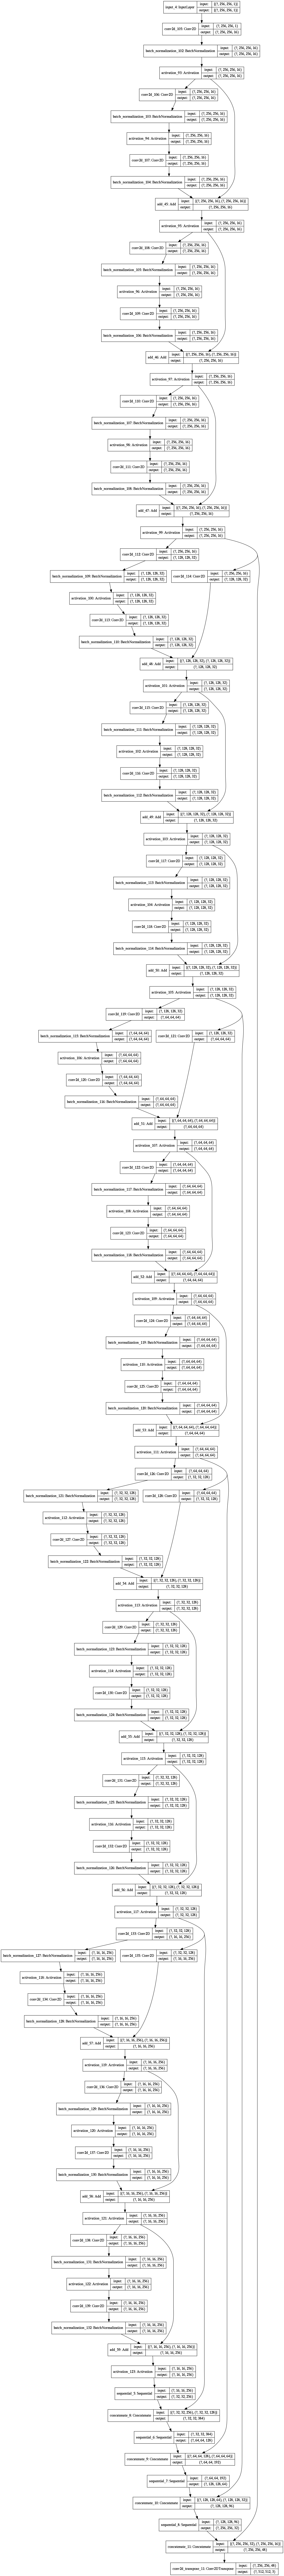

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    print(tf.shape(pred_mask[0]))
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for frame, mask in dataset.take(num):
            pred_mask = model.predict(frame)
            display([frame[0], mask[0], create_mask(pred_mask)])
    else:
        predicted = model.predict(sample_frame[tf.newaxis, ...])
        print(tf.shape(predicted))
        display([sample_frame, sample_mask,
                create_mask(predicted)])

tf.Tensor([  1 512 512   3], shape=(4,), dtype=int32)
tf.Tensor([512 512   1], shape=(3,), dtype=int32)


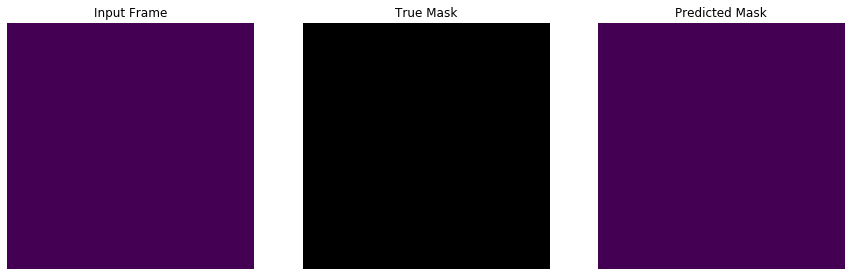

In [38]:
show_predictions()